In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from sequence_logo_helper_protein import plot_protein_logo

import pandas as pd

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[-1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


Using TensorFlow backend.


In [2]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.0005
test_set_size = 0.0995

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [3]:
#Sub-select smaller dataset

n_train_pos = 20000
n_train_neg = 20000

n_test_pos = 2000
n_test_neg = 2000

orig_n_train = train_index.shape[0]
orig_n_valid = valid_index.shape[0]
orig_n_test = test_index.shape[0]

train_index_pos = np.nonzero((pair_df.iloc[train_index]['interacts'] == 1).values)[0][:n_train_pos]
train_index_neg = np.nonzero((pair_df.iloc[train_index]['interacts'] == 0).values)[0][:n_train_neg]

train_index = np.concatenate([train_index_pos, train_index_neg], axis=0)
np.random.shuffle(train_index)

test_index_pos = np.nonzero((pair_df.iloc[test_index]['interacts'] == 1).values)[0][:n_test_pos] + orig_n_train + orig_n_valid
test_index_neg = np.nonzero((pair_df.iloc[test_index]['interacts'] == 0).values)[0][:n_test_neg] + orig_n_train + orig_n_valid

test_index = np.concatenate([test_index_pos, test_index_neg], axis=0)
np.random.shuffle(test_index)

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


Training set size = 40000
Test set size = 4000


In [4]:
#Calculate sequence lengths

pair_df['amino_seq_1_len'] = pair_df['amino_seq_1'].str.len()
pair_df['amino_seq_2_len'] = pair_df['amino_seq_2'].str.len()


In [5]:
pair_df.head()

,Unnamed: 0,monomer_id_1,monomer_id_2,amino_seq_1,amino_seq_2,interacts,amino_seq_1_len,amino_seq_2_len
0,0,redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...,TSEENVERQREHVRTTDEAIKEMEKIIRLLEVVARGEMDRDELRKV...,0.0,70,76
1,1,redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...,redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...,SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...,STEEVERIVEEVERISRRVVEISRRVVEKIRELIRRMKNERLVELL...,0.0,68,75
2,2,redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...,redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...,DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...,RTRELLDEHRKLLEEQERQTKQDEELLREVERRLREELIEMAKDVQ...,0.0,76,68
3,3,redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...,redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...,STEDIARELRKIIRRDKESKKEIKRVHDEQRELAKDAEDSRVVRRL...,GKEEVLEVAKRLLELQEKLQRLHEELQRILDDIVRRKNADDTLVRR...,0.0,76,73
4,4,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...,SEKEIIKRLNKLNEDLTRLLETYRRLVEEVERAGALEEELRRRQRE...,SEKEELKRLLEESNKLLELVKEQLRLAEDALRKIAKKARGEVEILE...,0.0,70,77


In [6]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [7]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1, data_ids=None) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=seq_length) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))

batch_size = 32

data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=(idx.shape[0] // batch_size) * batch_size,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_1_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}


In [8]:
#Load data matrices

[x_1_train, x_2_train, l_1_train, l_2_train], [y_train] = data_gens['train'][0]
[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = data_gens['test'][0]

print("x_1_train.shape = " + str(x_1_train.shape))
print("x_2_train.shape = " + str(x_2_train.shape))
print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))

print("l_1_train.shape = " + str(l_1_train.shape))
print("l2_train.shape = " + str(l_2_train.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l2_test.shape = " + str(l_2_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_1_train.shape = (40000, 1, 81, 20)
x_2_train.shape = (40000, 1, 81, 20)
x_1_test.shape = (4000, 1, 81, 20)
x_2_test.shape = (4000, 1, 81, 20)
l_1_train.shape = (40000, 1)
l2_train.shape = (40000, 1)
l_1_test.shape = (4000, 1)
l2_test.shape = (4000, 1)
y_train.shape = (40000, 1)
y_test.shape = (4000, 1)


In [9]:
#Define sequence templates

sequence_templates = [
    '$' * i + '@' * (seq_length - i)
    for i in range(seq_length+1)
]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]


In [10]:
#Calculate background distributions

pseudo_count = 0.1

x_means = []
x_mean_logits = []
for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_mean_len = (np.sum(x_train_len, axis=(0, 1)) + pseudo_count) / (np.sum(x_train_len, axis=(0, 1, 3)).reshape(-1, 1) + 20. * pseudo_count)
        x_mean_logits_len = np.log(x_mean_len)
        
        x_means.append(x_mean_len)
        x_mean_logits.append(x_mean_logits_len)
    else :
        x_means.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))
        x_mean_logits.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))


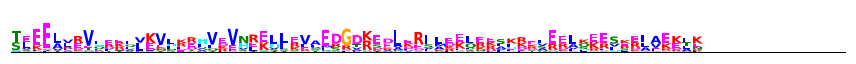

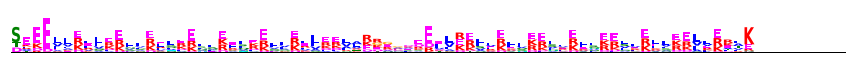

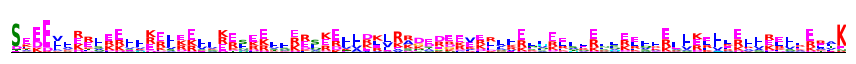

In [11]:
#Visualize a few background sequence distributions

visualize_len = 67

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 72

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 81

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)


In [11]:
#Calculate mean training set kl-divergence against background

mean_kl_divs = []

for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_train_clipped_len = np.clip(np.copy(x_train_len[:, 0, :, :]), 1e-8, 1. - 1e-8)

        kl_divs = np.sum(x_train_clipped_len * np.log(x_train_clipped_len / np.tile(np.expand_dims(x_means[i], axis=0), (x_train_clipped_len.shape[0], 1, 1))), axis=-1) / np.log(2.0)

        x_mean_kl_divs = np.sum(kl_divs * sequence_masks[i], axis=-1) / np.sum(sequence_masks[i])
        x_mean_kl_div = np.mean(x_mean_kl_divs)

        mean_kl_divs.append(x_mean_kl_div)
        
        print("[Length = " + str(i) + "] Mean KL Div against background (bits) = " + str(x_mean_kl_div))
    else :
        mean_kl_divs.append(0)


[Length = 67] Mean KL Div against background (bits) = 1.6907346997195756
[Length = 68] Mean KL Div against background (bits) = 2.5426583230333493
[Length = 69] Mean KL Div against background (bits) = 2.6963108899740424
[Length = 70] Mean KL Div against background (bits) = 2.6147464242917384
[Length = 71] Mean KL Div against background (bits) = 2.6557726761610625
[Length = 72] Mean KL Div against background (bits) = 2.683945218848393
[Length = 73] Mean KL Div against background (bits) = 2.6596332506944975
[Length = 74] Mean KL Div against background (bits) = 2.735911854268597
[Length = 75] Mean KL Div against background (bits) = 2.6119011622002315
[Length = 76] Mean KL Div against background (bits) = 2.6643661190465506
[Length = 77] Mean KL Div against background (bits) = 2.6779324826174045
[Length = 78] Mean KL Div against background (bits) = 2.624516823551134
[Length = 79] Mean KL Div against background (bits) = 2.640024204795844
[Length = 80] Mean KL Div against background (bits) = 2

In [12]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "coiled_coil_binders_alyssa"

data_df = pd.read_csv(experiment + ".csv", sep="\t")

print("len(data_df) = " + str(len(data_df)))

test_df = data_df.copy().reset_index(drop=True)

batch_size = 32
test_df = test_df.iloc[:(len(test_df) // batch_size) * batch_size].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))

print(test_df.head())


len(data_df) = 481
len(test_df) = 480
                                        monomer_id_1  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                        monomer_id_2  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                         amino_seq_1  \
0  DEEELLKLIEDLLKSNKELLDLSKKNLRLLRELVRERNMDDTALRK...   
1  SEKELLELLRELIEDLDRDVKLLRRNVDLHRRVAREGMREELIKKS...   
2  SEEERITEIVKRVEELLRRYEELVKEYKRVLEELRRELREEEQKEL...   
3  SDEEELDEIIKRSEEVMREVEEIDKRVEDIVRKAAKEGASELVKRS...   
4  TVKEL

In [13]:
#Construct test data

batch_size = 32

test_gen = iso.DataGenerator(
    np.arange(len(test_df), dtype=np.int),
    { 'df' : test_df },
    batch_size=(len(test_df) // batch_size) * batch_size,
    inputs = [
        {
            'id' : 'amino_seq_1',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_1'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: row['amino_seq_2'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_2'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_1_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_1']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_2']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'interacts',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['interacts'],
            'transformer' : NopTransformer(1),
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

#Load data matrices

[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = test_gen[0]

print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l_2_test.shape = " + str(l_2_test.shape))

print("y_test.shape = " + str(y_test.shape))


x_1_test.shape = (480, 1, 81, 20)
x_2_test.shape = (480, 1, 81, 20)
l_1_test.shape = (480, 1)
l_2_test.shape = (480, 1)
y_test.shape = (480, 1)


In [14]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

#Generator helper functions
def initialize_sequence_templates(generator, encoder, sequence_templates, background_matrices, model_suffix='') :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = encoder(sequence_template).reshape((1, len(sequence_template), 20))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['$', '@'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = 0.0
                onehot_template[:, j, nt_ix] = 1.0

        onehot_mask = np.zeros((1, len(sequence_template), 20))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == '$' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense' + model_suffix).set_weights([embedding_templates])
    generator.get_layer('template_dense' + model_suffix).trainable = False

    generator.get_layer('mask_dense' + model_suffix).set_weights([embedding_masks])
    generator.get_layer('mask_dense' + model_suffix).trainable = False
    
    generator.get_layer('background_dense' + model_suffix).set_weights([embedding_backgrounds])
    generator.get_layer('background_dense' + model_suffix).trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, model_suffix='') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 20))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='background_dense' + model_suffix)

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='template_dense' + model_suffix)
    onehot_mask_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='ones', name='mask_dense' + model_suffix)

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 20), name='masking_layer' + model_suffix)
    background_layer = Lambda(lambda x: x[0] + x[1] * x[2], name='background_layer' + model_suffix)
    
    def _sampler_func(class_input, scaled_pwm, scale) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm = masking_layer([background_layer([scaled_pwm, onehot_background, scale]), onehot_template, onehot_mask])
        
        return pwm, onehot_mask
    
    return _sampler_func


In [15]:
#Scrambler network definition

def load_scrambler_network(seq_length, model_suffix='') :

    #Discriminator network definition
    
    seed_input = Lambda(lambda x: K.zeros((1, 1), dtype=tf.int32))
    
    mask_dense = Embedding(1, seq_length, embeddings_initializer='glorot_normal', name='scrambler_mask_dense' + model_suffix)
    
    mask_reshape = Reshape((1, seq_length, 1))
    
    #mask_norm = BatchNormalization(axis=-1, name='scrambler_mask_norm' + model_suffix)
    
    mask_act = Activation('sigmoid')
    
    scale_inputs = Lambda(lambda x: x[1] * K.tile((1. - x[0]), (1, 1, 1, 20)), name='scrambler_input_scale' + model_suffix)
    
    def _scrambler_func(sequence_input) :

        #Final conv out
        #final_conv_out = mask_act(mask_norm(mask_reshape(mask_dense(seed_input(sequence_input))), training=True))
        final_conv_out = mask_act(mask_reshape(mask_dense(seed_input(sequence_input))))
        
        #Scale inputs by importance scores
        scaled_inputs = scale_inputs([final_conv_out, sequence_input])
        
        return scaled_inputs, final_conv_out

    return _scrambler_func


In [16]:
#Keras loss functions

def get_sigmoid_kl_divergence() :

    def _kl_divergence(y_true, y_pred) :

        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        return K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    return _kl_divergence

def get_margin_entropy_ame_masked(pwm_start, pwm_end) :
    
    def _margin_entropy_ame_masked(pwm, pwm_mask, pwm_background, max_bits) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / pwm_background[:, 0, pwm_start:pwm_end, :]) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        margin_conservation = K.switch(mean_conservation > K.constant(max_bits[:, 0], shape=(1,)), mean_conservation - K.constant(max_bits, shape=(1,)), K.zeros_like(mean_conservation))
    
        return margin_conservation
    
    return _margin_entropy_ame_masked

def get_target_entropy_sme_masked(pwm_start, pwm_end) :
    
    def _target_entropy_sme_masked(pwm, pwm_mask, pwm_background, target_bits) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / pwm_background[:, 0, pwm_start:pwm_end, :]) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        return (mean_conservation - target_bits[:, 0])**2
    
    return _target_entropy_sme_masked

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [17]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 81

#Load scrambler
scrambler_1 = load_scrambler_network(seq_length, model_suffix='_1')
scrambler_2 = load_scrambler_network(seq_length, model_suffix='_2')

#Load sampler
sampler_1 = build_sampler(batch_size, seq_length, n_classes=seq_length+1, model_suffix='_1')
sampler_2 = build_sampler(batch_size, seq_length, n_classes=seq_length+1, model_suffix='_2')


In [18]:
#Load predictor

predictor_path = 'saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5'

predictor = load_model(predictor_path, custom_objects={ 'sigmoid_nll' : get_sigmoid_kl_divergence() })
predictor.trainable = False
predictor.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=0.1))


In [19]:
#Create inverted labels

y_train_inv = 1. - y_train
y_test_inv = 1. - y_test


In [20]:
#Build scrambler model
scrambler_class_1 = Input(shape=(1,), name='scrambler_class_1')
scrambler_input_1 = Input(shape=(1, seq_length, 20), name='scrambler_input_1')
scrambler_class_2 = Input(shape=(1,), name='scrambler_class_2')
scrambler_input_2 = Input(shape=(1, seq_length, 20), name='scrambler_input_2')

scrambled_pwm_1, importance_scores_1 = scrambler_1(scrambler_input_1)
scrambled_pwm_2, importance_scores_2 = scrambler_2(scrambler_input_2)

pwm_1, pwm_mask_1 = sampler_1(scrambler_class_1, scrambled_pwm_1, importance_scores_1)
pwm_2, pwm_mask_2 = sampler_2(scrambler_class_2, scrambled_pwm_2, importance_scores_2)

zeropad_layer_1 = Lambda(lambda x: x[0] * x[1], name='zeropad_11')
zeropad_layer_2 = Lambda(lambda x: x[0] * x[1], name='zeropad_21')
sampled_pwm_zeropad_1 = zeropad_layer_1([pwm_1, pwm_mask_1])
sampled_pwm_zeropad_2 = zeropad_layer_2([pwm_2, pwm_mask_2])

scrambler_model = Model([scrambler_input_1, scrambler_class_1, scrambler_input_2, scrambler_class_2], [pwm_1, importance_scores_1, pwm_2, importance_scores_2])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, encoder, sequence_templates, x_means, model_suffix='_1')
initialize_sequence_templates(scrambler_model, encoder, sequence_templates, x_means, model_suffix='_2')

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [21]:
#Set target bits

conservation_target_bits = np.zeros(seq_length+1)
conservation_target_bits[:] = 2.4
conservation_target_bits = conservation_target_bits.tolist()

entropy_target_bits = np.zeros(seq_length+1)
entropy_target_bits[:] = 2.4
entropy_target_bits = entropy_target_bits.tolist()


In [22]:
#Helper function for setting sequence-length-specific parameters

def initialize_sequence_length_params(model, background_matrix_list, conservation_target_bits_list, entropy_target_bits_list) :

    flat_background_matrix_list = []
    flat_conservation_target_bits_list = []
    flat_entropy_target_bits_list = []

    for k in range(len(background_matrix_list)) :
        flat_background_matrix_list.append(background_matrix_list[k].reshape(1, -1))
        flat_conservation_target_bits_list.append(np.array([conservation_target_bits_list[k]]).reshape(1, -1))
        flat_entropy_target_bits_list.append(np.array([entropy_target_bits_list[k]]).reshape(1, -1))

    flat_background_matrix_list = np.concatenate(flat_background_matrix_list, axis=0)
    flat_conservation_target_bits_list = np.concatenate(flat_conservation_target_bits_list, axis=0)
    flat_entropy_target_bits_list = np.concatenate(flat_entropy_target_bits_list, axis=0)

    model.get_layer('x_mean_dense').set_weights([flat_background_matrix_list])
    model.get_layer('x_mean_dense').trainable = False

    model.get_layer('conservation_target_bits_dense').set_weights([flat_conservation_target_bits_list])
    model.get_layer('conservation_target_bits_dense').trainable = False
    
    model.get_layer('entropy_target_bits_dense').set_weights([flat_entropy_target_bits_list])
    model.get_layer('entropy_target_bits_dense').trainable = False


In [23]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class_1 = Input(shape=(1,), name='ae_scrambler_class_1')
ae_scrambler_input_1 = Input(shape=(1, seq_length, 20), name='ae_scrambler_input_1')
ae_scrambler_class_2 = Input(shape=(1,), name='ae_scrambler_class_2')
ae_scrambler_input_2 = Input(shape=(1, seq_length, 20), name='ae_scrambler_input_2')
ae_label_input = Input(shape=(1,), name='ae_label_input')

scrambled_in_1, importance_scores_1 = scrambler_1(ae_scrambler_input_1)
scrambled_in_2, importance_scores_2 = scrambler_2(ae_scrambler_input_2)

#Run encoder and decoder
scrambled_pwm_1, pwm_mask_1 = sampler_1(ae_scrambler_class_1, scrambled_in_1, importance_scores_1)
scrambled_pwm_2, pwm_mask_2 = sampler_2(ae_scrambler_class_2, scrambled_in_2, importance_scores_2)

zeropad_layer_1 = Lambda(lambda x: x[0] * x[1], name='zeropad_1')
zeropad_layer_2 = Lambda(lambda x: x[0] * x[1], name='zeropad_2')
scrambled_pwm_1_zeropad = zeropad_layer_1([scrambled_pwm_1, pwm_mask_1])
scrambled_pwm_2_zeropad = zeropad_layer_2([scrambled_pwm_2, pwm_mask_2])

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled = ae_label_input

#Make prediction on scrambled sequence samples
collapse_input_layer = Lambda(lambda x: x[:, 0, :, :], output_shape=(seq_length, 20))
collapsed_in_1 = collapse_input_layer(scrambled_pwm_1_zeropad)
collapsed_in_2 = collapse_input_layer(scrambled_pwm_2_zeropad)

y_pred_scrambled = predictor([collapsed_in_1, collapsed_in_2])

#Cost function parameters
pwm_start = 0
pwm_end = 81

#Define background matrix embeddings and target bits
seq_reshape_layer = Reshape((1, seq_length, 20))
flatten_bit_layer = Reshape((1,))

x_mean_dense = Embedding(seq_length+1, seq_length * 20, embeddings_initializer='zeros', name='x_mean_dense')
conservation_target_bits_dense = Embedding(seq_length+1, 1, embeddings_initializer='zeros', name='conservation_target_bits_dense')
entropy_target_bits_dense = Embedding(seq_length+1, 1, embeddings_initializer='zeros', name='entropy_target_bits_dense')

x_mean_len_1 = seq_reshape_layer(x_mean_dense(ae_scrambler_class_1))
x_mean_len_2 = seq_reshape_layer(x_mean_dense(ae_scrambler_class_2))

conservation_target_bits_len_1 = flatten_bit_layer(conservation_target_bits_dense(ae_scrambler_class_1))
conservation_target_bits_len_2 = flatten_bit_layer(conservation_target_bits_dense(ae_scrambler_class_2))

entropy_target_bits_len_1 = flatten_bit_layer(entropy_target_bits_dense(ae_scrambler_class_1))
entropy_target_bits_len_2 = flatten_bit_layer(entropy_target_bits_dense(ae_scrambler_class_2))

#NLL cost
nll_loss_func = get_sigmoid_kl_divergence()

#Conservation cost
conservation_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end)

#Entropy cost
entropy_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end)
#entropy_loss_func = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end)

#Define annealing coefficient
anneal_coeff = K.variable(0.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1]), name='nll')([
    y_pred_non_scrambled,
    y_pred_scrambled
])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff  * (0.5 * conservation_loss_func(x[0], x[1], x[2], x[3]) + 0.5 * conservation_loss_func(x[4], x[5], x[6], x[7])), name='conservation')([
    scrambled_pwm_1,
    pwm_mask_1,
    x_mean_len_1,
    conservation_target_bits_len_1,
    scrambled_pwm_2,
    pwm_mask_2,
    x_mean_len_2,
    conservation_target_bits_len_2
])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * (0.5 * entropy_loss_func(x[0], x[1], x[2], x[3]) + 0.5 * entropy_loss_func(x[4], x[5], x[6], x[7])), name='entropy')([
    scrambled_pwm_1,
    pwm_mask_1,
    x_mean_len_1,
    entropy_target_bits_len_1,
    scrambled_pwm_2,
    pwm_mask_2,
    x_mean_len_2,
    entropy_target_bits_len_2
])

loss_model = Model(
    [ae_scrambler_class_1, ae_scrambler_input_1, ae_scrambler_class_2, ae_scrambler_input_2, ae_label_input],
    [nll_loss, conservation_loss, entropy_loss]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(loss_model, encoder, sequence_templates, x_means, model_suffix='_1')
initialize_sequence_templates(loss_model, encoder, sequence_templates, x_means, model_suffix='_2')

#Initialize Sequence Length Parameters
initialize_sequence_length_params(loss_model, x_means, conservation_target_bits, entropy_target_bits)

opt = keras.optimizers.Adam(lr=0.01, beta_1=0.5, beta_2=0.9)

loss_model.compile(
    optimizer=opt,
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=10.0)
    }
)


In [24]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input_1 (InputLayer)  (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
scrambler_input_2 (InputLayer)  (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (1, 1)               0           scrambler_input_1[0][0]          
__________________________________________________________________________________________________
lambda_2 (Lambda)               (1, 1)               0           scrambler_input_2[0][0]          
__________________________________________________________________________________________________
scrambler_

In [25]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input_1 (InputLaye (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
ae_scrambler_input_2 (InputLaye (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (1, 1)               0           ae_scrambler_input_1[0][0]       
__________________________________________________________________________________________________
lambda_2 (Lambda)               (1, 1)               0           ae_scrambler_input_2[0][0]       
__________________________________________________________________________________________________
scrambler_

In [26]:
#Training configuration

#Define number of training epochs
n_iters = 600

#Define experiment suffix (optional)
experiment_suffix = "_kl_divergence_zeropad_continuous_mean_bg_per_example_longer_train"

model_name = "autoscrambler_dataset_" + dataset_name + "_inverted_scores_n_iters_" + str(n_iters) + "_target_bits_" + str(entropy_target_bits[0]).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_coiled_coil_binders_inverted_scores_n_iters_600_target_bits_24_kl_divergence_zeropad_continuous_mean_bg_per_example_longer_train


In [27]:
#(Re-)Initialize scrambler mask

def reset_generator(scrambler_model, verbose=False) :
    session = K.get_session()
    for layer in scrambler_model.layers :
        if 'scrambler' in layer.name :
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg,'initializer'):
                    initializer_method = getattr(v_arg, 'initializer')
                    initializer_method.run(session=session)
                    if verbose :
                        print('reinitializing layer {}.{}'.format(layer.name, v))

#(Re-)Initialize Optimizer

def reset_optimizer(opt, verbose=False) :
    session = K.get_session()
    for v in opt.__dict__:
        v_arg = getattr(opt, v)
        if hasattr(v_arg,'initializer'):
            initializer_method = getattr(v_arg, 'initializer')
            initializer_method.run(session=session)
            if verbose :
                print('reinitializing optimizer parameter {}'.format(v))


In [28]:
#Reset mask
reset_generator(scrambler_model, verbose=True)
reset_generator(loss_model, verbose=True)
reset_optimizer(opt, verbose=True)

reinitializing layer scrambler_mask_dense_1.embeddings
reinitializing layer scrambler_mask_dense_2.embeddings
reinitializing layer scrambler_mask_dense_1.embeddings
reinitializing layer scrambler_mask_dense_2.embeddings
reinitializing optimizer parameter iterations
reinitializing optimizer parameter lr
reinitializing optimizer parameter beta_1
reinitializing optimizer parameter beta_2
reinitializing optimizer parameter decay


In [29]:
#Execute training procedure

s_test = np.zeros((1, 1))

pwm_1_test = []
pwm_2_test = []

importance_scores_1_test = []
importance_scores_2_test = []

for data_ix in range(x_1_test.shape[0]) :
    
    if data_ix % 100 == 0 :
        print("Optimizing example " + str(data_ix) + "...")
    
    # train the autoencoder
    _ = loss_model.fit(
        [l_1_test[data_ix:data_ix+1], x_1_test[data_ix:data_ix+1], l_2_test[data_ix:data_ix+1], x_2_test[data_ix:data_ix+1], y_test_inv[data_ix:data_ix+1]],
        [s_test, s_test, s_test],
        epochs=1,
        steps_per_epoch=n_iters
    )
    
    temp_pwm_1, temp_importance_scores_1, temp_pwm_2, temp_importance_scores_2 = scrambler_model.predict_on_batch(x=[x_1_test[data_ix:data_ix+1], l_1_test[data_ix:data_ix+1], x_2_test[data_ix:data_ix+1], l_2_test[data_ix:data_ix+1]])
    
    pwm_1_test.append(temp_pwm_1)
    pwm_2_test.append(temp_pwm_2)
    
    importance_scores_1_test.append(temp_importance_scores_1)
    importance_scores_2_test.append(temp_importance_scores_2)
    
    #Reset mask
    reset_generator(scrambler_model)
    reset_generator(loss_model)
    reset_optimizer(opt)


Optimizing example 0...
Epoch 1/1
600/600 [==============================] - 20s 33ms/step - loss: 5.9951 - nll_loss: 0.3588 - conservation_loss: 0.0000e+00 - entropy_loss: 5.6363
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 6.2545 - nll_loss: 0.9490 - conservation_loss: 0.0000e+00 - entropy_loss: 5.3055
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 5.8407 - nll_loss: 0.3610 - conservation_loss: 0.0000e+00 - entropy_loss: 5.4797
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 4.2488 - nll_loss: 0.2637 - conservation_loss: 0.0000e+00 - entropy_loss: 3.9851
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 2.7732 - nll_loss: 0.1293 - conservation_loss: 0.0000e+00 - entropy_loss: 2.6439
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.4731 - nll_loss: 0.0689 - conservation_loss: 0.0000e+00 - entropy_loss: 3.4042
Epoch 1/1
600/600 [=====================

600/600 [==============================] - 17s 28ms/step - loss: 6.4832 - nll_loss: 0.5406 - conservation_loss: 0.0000e+00 - entropy_loss: 5.9426
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 4.6121 - nll_loss: 0.8906 - conservation_loss: 0.0000e+00 - entropy_loss: 3.7215
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.5612 - nll_loss: 0.0371 - conservation_loss: 0.0000e+00 - entropy_loss: 3.5241
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.1298 - nll_loss: 0.9055 - conservation_loss: 0.0000e+00 - entropy_loss: 4.2242
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 4.6597 - nll_loss: 0.1525 - conservation_loss: 0.0000e+00 - entropy_loss: 4.5072
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.6324 - nll_loss: 0.7489 - conservation_loss: 0.0000e+00 - entropy_loss: 4.8835
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss:

600/600 [==============================] - 17s 28ms/step - loss: 3.4500 - nll_loss: 0.2602 - conservation_loss: 0.0000e+00 - entropy_loss: 3.1898
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.8640 - nll_loss: 0.2168 - conservation_loss: 0.0000e+00 - entropy_loss: 3.6472
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 4.5246 - nll_loss: 0.0392 - conservation_loss: 0.0000e+00 - entropy_loss: 4.4853
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.4446 - nll_loss: 0.1093 - conservation_loss: 0.0000e+00 - entropy_loss: 5.3353
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.5954 - nll_loss: 0.0511 - conservation_loss: 0.0000e+00 - entropy_loss: 3.5443
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.2530 - nll_loss: 1.0212 - conservation_loss: 0.0000e+00 - entropy_loss: 4.2318
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss:

600/600 [==============================] - 17s 28ms/step - loss: 5.2395 - nll_loss: 0.3541 - conservation_loss: 0.0000e+00 - entropy_loss: 4.8854
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 4.1787 - nll_loss: 0.2157 - conservation_loss: 0.0000e+00 - entropy_loss: 3.9630
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 4.3775 - nll_loss: 0.1467 - conservation_loss: 0.0000e+00 - entropy_loss: 4.2308
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.8904 - nll_loss: 0.3111 - conservation_loss: 0.0000e+00 - entropy_loss: 3.5792
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 4.5470 - nll_loss: 0.2729 - conservation_loss: 0.0000e+00 - entropy_loss: 4.2741
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.5741 - nll_loss: 0.2054 - conservation_loss: 0.0000e+00 - entropy_loss: 3.3687
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss:

600/600 [==============================] - 17s 28ms/step - loss: 5.0121 - nll_loss: 0.6863 - conservation_loss: 0.0000e+00 - entropy_loss: 4.3258
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.8502 - nll_loss: 0.4134 - conservation_loss: 0.0000e+00 - entropy_loss: 3.4369
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.7574 - nll_loss: 0.6982 - conservation_loss: 0.0000e+00 - entropy_loss: 5.0592
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.7309 - nll_loss: 0.8339 - conservation_loss: 0.0000e+00 - entropy_loss: 4.8970
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 5.3847 - nll_loss: 0.9640 - conservation_loss: 0.0000e+00 - entropy_loss: 4.4206
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 6.0430 - nll_loss: 0.7831 - conservation_loss: 0.0000e+00 - entropy_loss: 5.2599
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss:

600/600 [==============================] - 16s 27ms/step - loss: 5.6452 - nll_loss: 0.6468 - conservation_loss: 0.0000e+00 - entropy_loss: 4.9984
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.5897 - nll_loss: 0.9491 - conservation_loss: 0.0000e+00 - entropy_loss: 4.6406
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 5.1546 - nll_loss: 0.7281 - conservation_loss: 0.0000e+00 - entropy_loss: 4.4265
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 5.2105 - nll_loss: 1.1164 - conservation_loss: 0.0000e+00 - entropy_loss: 4.0940
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.7908 - nll_loss: 0.7473 - conservation_loss: 0.0000e+00 - entropy_loss: 5.0435
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 6.3912 - nll_loss: 0.4211 - conservation_loss: 0.0000e+00 - entropy_loss: 5.9701
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss:

600/600 [==============================] - 19s 32ms/step - loss: 4.4118 - nll_loss: 0.5447 - conservation_loss: 0.0000e+00 - entropy_loss: 3.8672
Epoch 1/1
600/600 [==============================] - 19s 32ms/step - loss: 4.5095 - nll_loss: 0.5317 - conservation_loss: 0.0000e+00 - entropy_loss: 3.9778
Epoch 1/1
600/600 [==============================] - 19s 32ms/step - loss: 5.2326 - nll_loss: 0.3498 - conservation_loss: 0.0000e+00 - entropy_loss: 4.8829
Epoch 1/1
600/600 [==============================] - 19s 32ms/step - loss: 4.8498 - nll_loss: 0.5869 - conservation_loss: 0.0000e+00 - entropy_loss: 4.2628
Epoch 1/1
600/600 [==============================] - 19s 32ms/step - loss: 5.6376 - nll_loss: 1.1581 - conservation_loss: 0.0000e+00 - entropy_loss: 4.4796
Epoch 1/1
600/600 [==============================] - 19s 31ms/step - loss: 2.8017 - nll_loss: 0.2462 - conservation_loss: 0.0000e+00 - entropy_loss: 2.5555
Epoch 1/1
600/600 [==============================] - 19s 32ms/step - loss:

600/600 [==============================] - 17s 28ms/step - loss: 4.2165 - nll_loss: 0.2198 - conservation_loss: 0.0000e+00 - entropy_loss: 3.9967
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.1426 - nll_loss: 0.5029 - conservation_loss: 0.0000e+00 - entropy_loss: 4.6397
Epoch 1/1
600/600 [==============================] - 18s 30ms/step - loss: 5.6716 - nll_loss: 0.1848 - conservation_loss: 0.0000e+00 - entropy_loss: 5.4867
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 4.7608 - nll_loss: 0.4580 - conservation_loss: 0.0000e+00 - entropy_loss: 4.3029
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.9953 - nll_loss: 0.0511 - conservation_loss: 0.0000e+00 - entropy_loss: 3.9442
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.3846 - nll_loss: 0.5255 - conservation_loss: 0.0000e+00 - entropy_loss: 4.8591
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss:

600/600 [==============================] - 16s 27ms/step - loss: 3.2782 - nll_loss: 0.3077 - conservation_loss: 0.0000e+00 - entropy_loss: 2.9706
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 4.1412 - nll_loss: 0.0644 - conservation_loss: 0.0000e+00 - entropy_loss: 4.0768
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 4.6193 - nll_loss: 0.3131 - conservation_loss: 0.0000e+00 - entropy_loss: 4.3062
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 4.2240 - nll_loss: 0.2568 - conservation_loss: 0.0000e+00 - entropy_loss: 3.9672
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 3.2439 - nll_loss: 0.1218 - conservation_loss: 0.0000e+00 - entropy_loss: 3.1221
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 5.8116 - nll_loss: 0.4411 - conservation_loss: 0.0000e+00 - entropy_loss: 5.3706
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss:

600/600 [==============================] - 17s 28ms/step - loss: 5.6263 - nll_loss: 0.6551 - conservation_loss: 0.0000e+00 - entropy_loss: 4.9712
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.3343 - nll_loss: 0.1743 - conservation_loss: 0.0000e+00 - entropy_loss: 5.1600
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.2254 - nll_loss: 0.3809 - conservation_loss: 0.0000e+00 - entropy_loss: 4.8444
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 5.4980 - nll_loss: 0.2898 - conservation_loss: 0.0000e+00 - entropy_loss: 5.2081
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss: 4.7836 - nll_loss: 0.2363 - conservation_loss: 0.0000e+00 - entropy_loss: 4.5473
Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 4.8033 - nll_loss: 0.6474 - conservation_loss: 0.0000e+00 - entropy_loss: 4.1559
Epoch 1/1
600/600 [==============================] - 17s 28ms/step - loss:

Test sequence 0:
Binder 1:


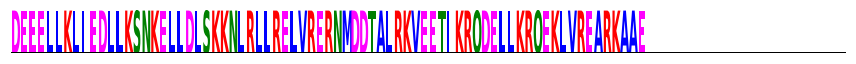

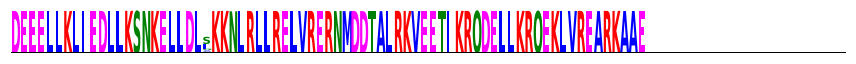

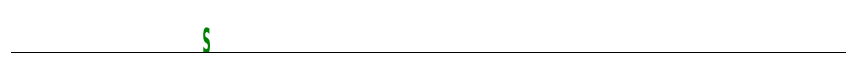

Binder 2:


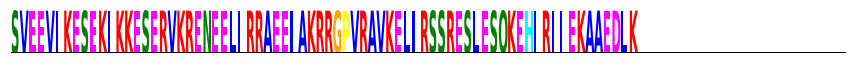

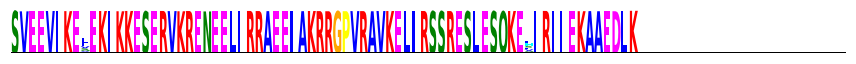

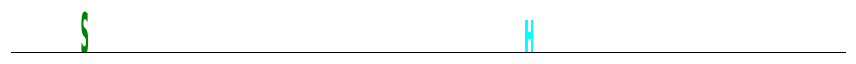

Test sequence 1:
Binder 1:


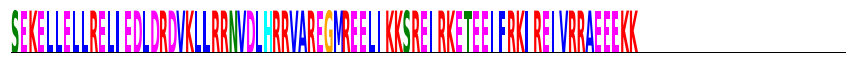

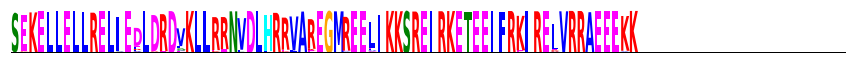

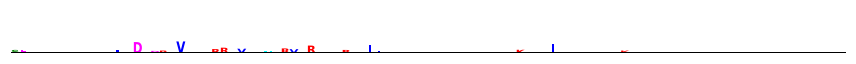

Binder 2:


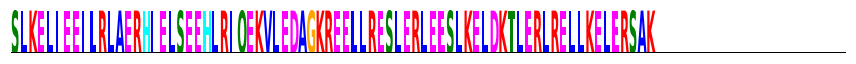

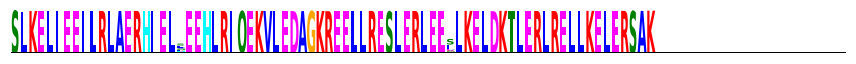

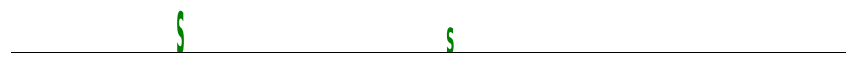

Test sequence 2:
Binder 1:


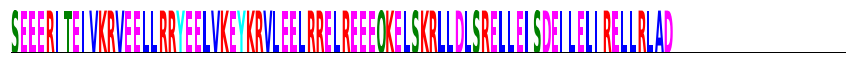

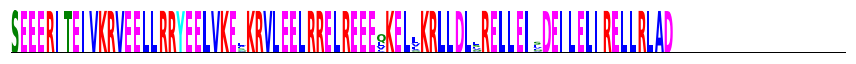

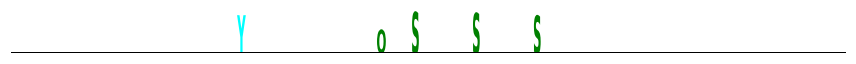

Binder 2:


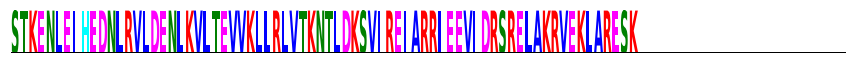

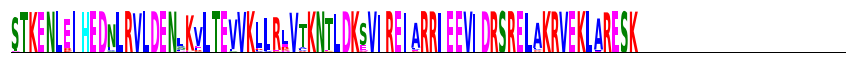

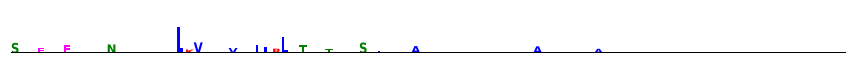

Test sequence 3:
Binder 1:


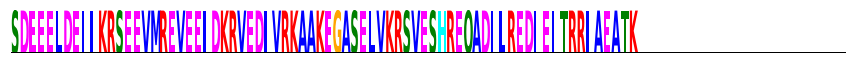

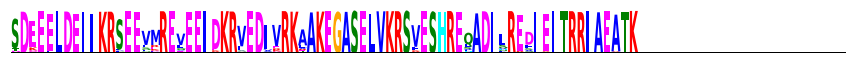

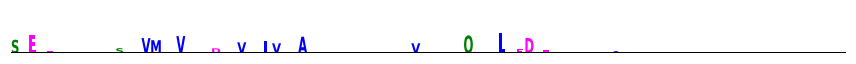

Binder 2:


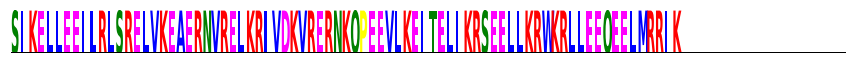

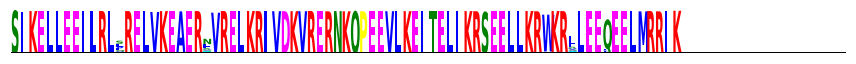

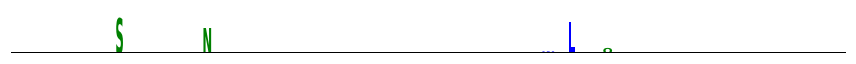

Test sequence 4:
Binder 1:


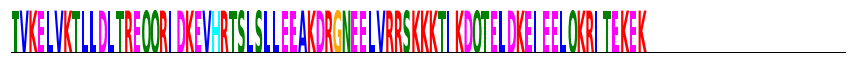

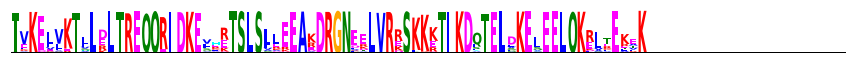

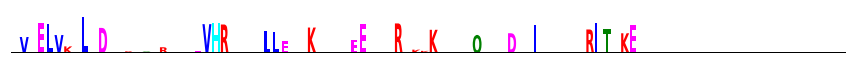

Binder 2:


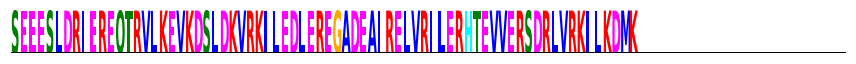

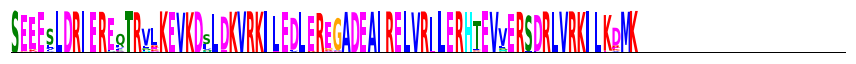

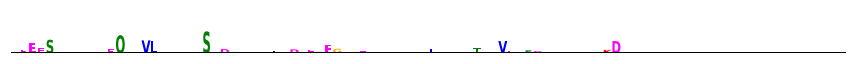

In [30]:
#Visualize a few reconstructed sequence patterns

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    print("Binder 1:")
    
    subtracted_pwm_1_test = x_1_test[plot_i:plot_i+1] * importance_scores_1_test[plot_i]
    
    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_templates[l_1_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)
    plot_protein_logo(residue_map, pwm_1_test[plot_i][0, 0, :, :], sequence_template=sequence_templates[l_1_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)
    plot_protein_logo(residue_map, subtracted_pwm_1_test[0, 0, :, :], sequence_template=sequence_templates[l_1_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)

    print("Binder 2:")
    
    subtracted_pwm_2_test = x_2_test[plot_i:plot_i+1] * importance_scores_2_test[plot_i]
    
    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_templates[l_2_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)
    plot_protein_logo(residue_map, pwm_2_test[plot_i][0, 0, :, :], sequence_template=sequence_templates[l_2_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)
    plot_protein_logo(residue_map, subtracted_pwm_2_test[0, 0, :, :], sequence_template=sequence_templates[l_2_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)


In [31]:

importance_scores_1 = np.concatenate(importance_scores_1_test, axis=0)
importance_scores_2 = np.concatenate(importance_scores_2_test, axis=0)


In [32]:
#Store importance scores

flat_importance_scores_1 = importance_scores_1[:, 0, :, 0]
flat_importance_scores_2 = importance_scores_2[:, 0, :, 0]

short_model_name = "occlusion_target_bits_" + str(entropy_target_bits[0]).replace(".", "") + "_n_iters_" + str(n_iters) + experiment_suffix

np.save(experiment + "_model_" + short_model_name + "_testset_importance_scores_1", flat_importance_scores_1)
np.save(experiment + "_model_" + short_model_name + "_testset_importance_scores_2", flat_importance_scores_2)
